In [4]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from os.path import join as oj
import sys
sys.path.append('../vision_fit')
import numpy as np
from copy import deepcopy
import pickle as pkl
from torch.optim.lr_scheduler import StepLR
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import models
from dim_reduction import *
%load_ext autoreload
%autoreload 2

# reduce model by projecting onto pcs that explain "percent_to_explain"
def reduce_model(model, percent_to_explain=0.85):
    model_r = deepcopy(model)
    weight_dict = model_r.state_dict()
    weight_dict_new = deepcopy(model_r.state_dict())
#     print(weight_dict)
    for layer_name in weight_dict.keys():
        if 'weight' in layer_name:
            w = weight_dict[layer_name]
            
            # get number of components
            pca = PCA(n_components=w.shape[1])
            pca.fit(w)
            explained_vars = pca.explained_variance_ratio_
            dim, perc_explained = 0, 0
            while perc_explained <= percent_to_explain:
                perc_explained += explained_vars[dim]
                dim += 1
            
            # actually project
            pca = PCA(n_components=dim)            
            w2 = pca.inverse_transform(pca.fit_transform(w))
            print('shapes', w.shape, w2.shape)
            weight_dict_new[layer_name] = torch.Tensor(w2)
            
    model_r.load_state_dict(weight_dict_new)
    return model_r

             
modelm = models.MnistNet()        
modelr = reduce_model(modelm)

shapes torch.Size([500, 784]) (500, 784)
shapes torch.Size([256, 500]) (256, 500)
shapes torch.Size([10, 256]) (10, 256)


In [5]:
print(modelm.state_dict()['fc1.weight'][:10].numpy().shape)

(10, 784)


fc1.weight torch.Size([500, 784])
True
fc1.bias torch.Size([500])
True
fc2.weight torch.Size([256, 500])
False
fc2.bias torch.Size([256])
False
fc3.weight torch.Size([10, 256])
False
fc3.bias torch.Size([10])
False


In [3]:
from params_vision import p
np.random.seed(p.seed) 
torch.manual_seed(p.seed)    
use_cuda = torch.cuda.is_available()

batch_size = 100
root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data', p.dset)
if not os.path.exists(root):
    os.mkdir(root)


## load mnist dataset     

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
model = models.MnistNet()  
if use_cuda:
    model = model.cuda()



Processing...
Done!


In [7]:
train_set.targets

AttributeError: 'MNIST' object has no attribute 'targets'

In [2]:
train_set.train_data.shape

NameError: name 'train_set' is not defined

In [10]:
d = torch.Tensor(np.random.randn(60000, 28, 28))
print(d.shape)

torch.Size([60000, 28, 28])


In [12]:
train_set.train_labels = torch.Tensor(np.random.randint(0, 10, 60000)).long()

In [14]:
np.random.randint(0, 10, 60000)

array([8, 8, 4, ..., 6, 0, 1])

In [37]:
test_set.

torch.Size([10000, 8, 8])


5
13


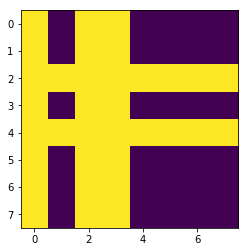

In [38]:
plt.imshow(bars[0])
print(labs[0])
print(np.max(labs))

In [10]:
root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data', 'cifar10')
train_set = dset.CIFAR10(root=root, train=True, download=True, transform=trans)

Files already downloaded and verified


In [14]:
len(train_set.train_labels), type(train_set.train_labels[0])

(50000, int)